In [1]:
%matplotlib inline
%run ./lorenz_system.py
from matplotlib import cm
import numpy as np
import urllib2
import random
import math

In [2]:
stepCnt = 2500

In [3]:
xs,ys,zs = build_system(stepCnt)

# Lorenz System

$$
\dfrac{dx}{dt} = \sigma(y-x), \dfrac{dy}{dt} = x(\rho -z) - y, \dfrac{dz}{dt} = xy-\beta z
$$

# Baseline Plots

## 3d Plot

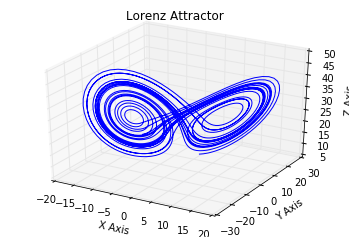

In [4]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(xs, ys, zs)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

## 2d Plots

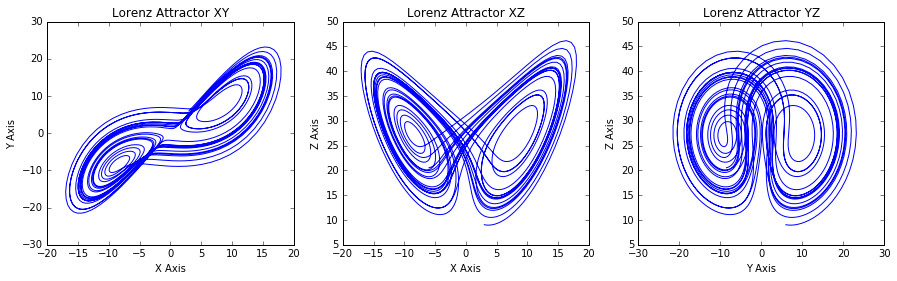

In [5]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.set_figwidth(15)
ax1.plot(xs, ys)
ax1.set_xlabel("X Axis")
ax1.set_ylabel("Y Axis")
ax1.set_title("Lorenz Attractor XY")

ax2.plot(xs, zs)
ax2.set_xlabel("X Axis")
ax2.set_ylabel("Z Axis")
ax2.set_title("Lorenz Attractor XZ")

ax3.plot(ys, zs)
ax3.set_xlabel("Y Axis")
ax3.set_ylabel("Z Axis")
ax3.set_title("Lorenz Attractor YZ")

# Wind Direction

In [6]:
def get_wind_angle(p1, p2):
    ''' 
    return slope between the two points
    '''
    # get slope
    slope = (p2[len(p2) - 1] - p2[0]) / (p1[len(p1) - 1] - p1[0])

    # get direction of line
    # 1  = up
    # -1 = down
    direction = 1 
    
    if p2[0] < p2[len(p2) - 1]:
        direction = -1
    elif p2[0] > p2[len(p2) - 1]:
        direction = 1
    else:
        direction = 0
    
    # initialize theta
    theta = 0
    
    if direction == 0:
        # this is a straight line
        theta = 0 if p1[0] < p1[len(p1) - 1] else 180
    elif p2[len(p2) - 1] == p2[0]:
        theta = 90 if direction == 1 else 270
    else:
        # get angle in  degrees, atan(y / x)
        theta = math.degrees(math.atan2(slope, 1))

        # get angle relative to whole graph
        if theta < 0 and direction == 1:
            theta = (theta * -1) + 90
        elif theta < 0 and direction == -1:
            theta = (theta * -1) + 180
        elif theta >= 0 and direction == -1:
            theta += 270
    
    return math.radians(theta)

In [7]:
def build_wind_angles(coords_a, coords_b, iterator = 10):
    '''
    build list of wind angles
    
    Paramters:
        coords_a - part a of coordinate linking up with coords_b
        coords_b - part b of coordiante linking up with coords a
    '''
    a      = []
    b      = []
    angles = []

    for minimum in range(0, len(coords_a) - iterator, iterator):
        maximum = minimum + iterator

        # store info
        a.append(ys[minimum])
        b.append(zs[minimum])
        angles.append(get_wind_angle(coords_a[minimum:maximum], coords_b[minimum:maximum]))
    

    return a, b, angles

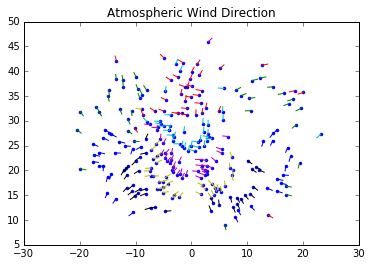

In [8]:
# look into: http://matplotlib.org/examples/pylab_examples/quiver_demo.html
x,y,angles = build_wind_angles(ys,zs)

line = plt.figure()

plt.plot(x, y, ".")

for i in range(len(angles)):
    angle = angles[i]
    x_cor = x[i]
    y_cor = y[i]
    
    plt.plot([x_cor, x_cor + math.cos(angle)], [y_cor, y_cor + math.sin(angle)])

plt.title("Atmospheric Wind Direction")

# Lorenz Attractor Centers

## Derivation

$$
Q = (\pm \sqrt{b(r-1)}, \pm \sqrt{b(r-1)}, r-1 )
$$

In [9]:
def get_yz_centers(b,r,one=False):
    x = math.sqrt(const_b*(const_r - 1))
    y = math.sqrt(const_b*(const_r - 1))
    z = r - 1
    
    if one:
        return y,z
    else:
        return (y,-y), (z,z)

## Plot

In [10]:
y_center, z_center = get_yz_centers(const_b, const_r)
one_x,one_y,one_z = build_system(stepCnt,s=2)

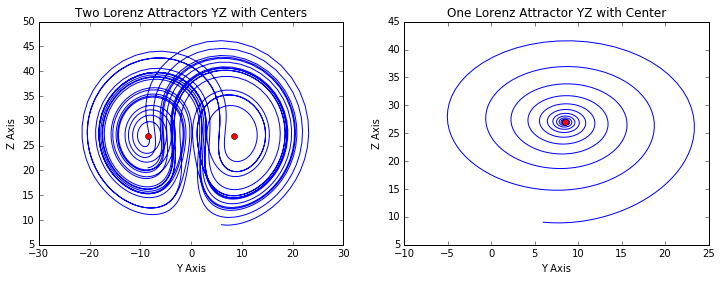

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_figwidth(12)

ax1.plot(ys, zs)
ax1.plot(y_center,z_center,'ro')
ax1.set_xlabel("Y Axis")
ax1.set_ylabel("Z Axis")
ax1.set_title("Two Lorenz Attractors YZ with Centers")

ax2.plot(one_y, one_z)
ax2.plot(y_center[0],z_center[0],'ro')
ax2.set_xlabel("Y Axis")
ax2.set_ylabel("Z Axis")
ax2.set_title("One Lorenz Attractor YZ with Center")

plt.show()

## Results

One center requires use of positive y and z.

Two centers requires use of both positive and negative y and positive z to match both.

# Isobar Grouping

$$
dist = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}
$$

In [12]:
def dist(p1, p2):
    '''
    return distance between two coordinates
    
    Parameters:
        p1 - xy coordinates
        p2 - xy coordinates
        
    Return:
        float - distnace between p1 and p2
    '''
    return math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

In [13]:
def format_cluster_points(x_axis, y_axis, center):
    '''
    format cluster points with the distance to the center included
    
    Parameters:
        x_axis     - array containing coordinate adjace to y_axis
        y_axis     - array containing coordinate adjace to x_axis
        center_one - coordiantes for Lorenz Attractor one\
    
    Return:
        attractor_one_points - array for Lorenz Attractor one with
                               a calculated distnace
    '''
    attractor_points  = []
    
    for i in range(len(x_axis)):
        point = (x_axis[i], y_axis[i])
        distance = dist(point, center)
        
        point = {
            'coord': point,
            'dist': distance
        }
        attractor_points.append(point)
        
    return attractor_points

In [14]:
def cluster_low_hi_points(x_axis, y_axis, center_one, center_two):
    '''
    format points by distance closest to center one or two. Include
    distance in new arrays that are returned
    
    Parameters:
        x_axis     - array containing coordinate adjace to y_axis
        y_axis     - array containing coordinate adjace to x_axis
        center_one - coordiantes for Lorenz Attractor one
        center_two - coordinates for Lorenz Attractor two
    
    Return:
        attractor_one_points - array for Lorenz Attractor one with
                               a calculated distnace
        attractor_two_points - array for Lorenz Attractor two with
                               a calculated distance
    '''
    attractor_one_points  = []
    attractor_two_points  = []
    
    for i in range(len(x_axis)):
        point = (x_axis[i], y_axis[i])
        cent_one_dist = dist(point, center_one)
        cent_two_dist = dist(point, center_two)
        
        if cent_one_dist < cent_two_dist:
            point = {
                'coord': point,
                'dist': cent_one_dist
            }
            attractor_one_points.append(point)
        else:
            point = {
                'coord': point,
                'dist': cent_two_dist
            }
            attractor_two_points.append(point)
    
    return attractor_one_points, attractor_two_points

Standard Deviation Formula:
$$
\sigma = \sqrt{\dfrac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2}
$$

In [15]:
def compute_attractor_distance_standard_deviation(attractor):
    '''
    compute the standard deviation of the distance of the points to 
    the attractor
    
    Paramaters:
        attractor - one of the return results computed in funciton 
                    cluster_low_hi_points
                    
    Return:
        float - standard deviation
    '''
    # calculate the mean
    mean = 0
    for i in range(len(attractor)):
        mean += attractor[i]['dist']
    mean /= len(attractor)
    
    # Perform summation
    summation = 0
    for i in range(len(attractor)):
        summation += (attractor[i]['dist'] - mean)**2
        
    # divide summation by N
    summation /= len(attractor)
    
    # return square root
    return math.sqrt(summation)

$$
\sigma x = dist \\
x = \dfrac{dist}{\sigma}
$$

In [16]:
def cluster_attractor_groups(attractor, attractor_std):
    '''
    cluster points together by standard deviation using above formula
    to calculate the index for the array
    
    Parameters:
        attractor        - array of points attracted
        attractor_std    - standard devation of points attracted
        
    Return:
        attractor_groups - matrix with groups by index of closest to furthest
    '''
    attractor_groups = []
    
    for point in attractor:
        std_index = int(point['dist'] / attractor_std)

        # check if array needs to be extended
        if len(attractor_groups) - 1 < std_index:
            attractor_groups.extend([{'min': sys.maxint, 
                                      'max': -1,
                                      'data': []
                                     } for i in range(std_index + 1 - len(attractor_groups))])

        if point['dist'] < attractor_groups[std_index]['min']:
            # assign min
            attractor_groups[std_index]['min'] = point['dist']
        if point['dist'] > attractor_groups[std_index]['max']:
            # assign max
            attractor_groups[std_index]['max'] = point['dist']
        
        # add point to array
        attractor_groups[std_index]['data'].append(point)
    
    return attractor_groups

In [17]:
def format_attractor_groups_plot(attractor):
    '''
    turn an attactor group into a plottable format
    
    Parameters:
        attractor - attractor group created in cluster_attractor_groups
        
    Return:
        x         - array of x points to plot
        y         - array of y points to plot
    '''
    x = []
    y = []
    
    for i in range(len(attractor)):
        x.append([])
        y.append([])
        
        for j in range(len(attractor[i]['data'])):
            x[i].append(attractor[i]['data'][j]['coord'][0])
            y[i].append(attractor[i]['data'][j]['coord'][1])
    
    return x,y

In [18]:
def convert_groups_low_hi(attractor_group_one, attractor_group_two):
    '''
    count the total size of the groups to decide which is low and which 
    is high pressure.
    
    Parameters:
        attractor_group_one - matrix built by cluster_attractor_groups
        attractor_group_two - matrix built by cluster_attractor_groups
        
    Return:
        low  - highest count attractor group
        high - lowest count attractor group
    '''
    one = 0
    two = 0
    for i in range(len(attractor_group_one)):
        one += len(attractor_group_one[i])
    for i in range(len(attractor_group_two)):
        two += len(attractor_group_two[i])
        
    if one > two:
        return attractor_group_one, attractor_group_two
    return attractor_group_two, attractor_group_one

In [19]:
def plot_centers(ax, low_press, center_y, center_z):
    if dist(low_press[1]['data'][1]['coord'], (center_y[0],center_z[0])):
        ax.text(center_y[0], center_z[0], 'H',
                 verticalalignment='center', horizontalalignment='center',
                 color='red', fontsize=30)
        ax.text(center_y[1], center_z[1], 'L',
                 verticalalignment='center', horizontalalignment='center',
                 color='blue', fontsize=30)
    else:
        ax.text(center_y[1], center_z[1], 'H',
                 verticalalignment='center', horizontalalignment='center',
                 color='red', fontsize=30)
        ax.text(center_y[0], center_z[0], 'L',
                 verticalalignment='center', horizontalalignment='center',
                 color='blue', fontsize=30)

## Two Centers

In [20]:
xs_two,ys_two,zs_two       = build_system(stepCnt, s=10)
x_two,y_two,angles_two     = build_wind_angles(ys_two,zs_two)
y_two_center, z_two_center = get_yz_centers(const_b, const_r)

In [21]:
attractor_one, attractor_two = cluster_low_hi_points(x_two,\
                                                     y_two,\
                                                     (y_two_center[0], z_two_center[0]),\
                                                     (y_two_center[1], z_two_center[1]))

In [22]:
attractor_one_std = compute_attractor_distance_standard_deviation(attractor_one)
attractor_two_std = compute_attractor_distance_standard_deviation(attractor_two)

In [23]:
attractor_one_groups = cluster_attractor_groups(attractor_one, 4)
attractor_two_groups = cluster_attractor_groups(attractor_two, 4)

In [24]:
low_pressure_group, high_pressure_group = convert_groups_low_hi(attractor_one_groups, attractor_two_groups)

In [25]:
low_x, low_y   = format_attractor_groups_plot(low_pressure_group)
high_x, high_y = format_attractor_groups_plot(high_pressure_group)

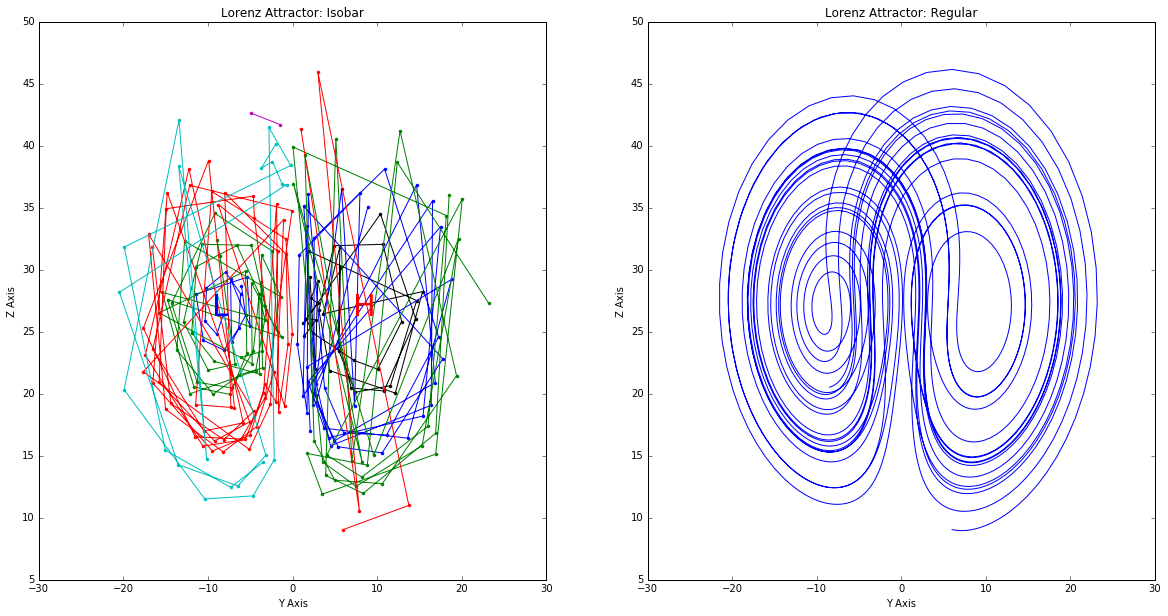

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_figheight(10)
f.set_figwidth(20)

for i in range(len(low_x)):
    if len(low_x[i]) > 0:
        ax1.plot(low_x[i], low_y[i],'.-')
        
for i in range(len(high_x)):
    if len(high_x[i]) > 0:
        ax1.plot(high_x[i], high_y[i],'.-')

# Graph Centers
plot_centers(ax1, low_pressure_group, y_two_center, z_two_center)

ax1.set_xlabel("Y Axis")
ax1.set_ylabel("Z Axis")
ax1.set_title("Lorenz Attractor: Isobar")

ax2.plot(ys_two,zs_two)
ax2.set_xlabel("Y Axis")
ax2.set_ylabel("Z Axis")
ax2.set_title("Lorenz Attractor: Regular")

plt.show()

## One Center

In [27]:
xs,ys,zs = build_system(stepCnt, s = 2)
x,y,angles = build_wind_angles(ys,zs)
y_center, z_center = get_yz_centers(const_b, const_r)

In [28]:
attractor = format_cluster_points(x,y,(y_center[0], z_center[0]))

In [29]:
attractor_std = compute_attractor_distance_standard_deviation(attractor)

In [30]:
attractor_groups = cluster_attractor_groups(attractor, attractor_std)

In [31]:
a_x, a_y = format_attractor_groups_plot(attractor_groups)

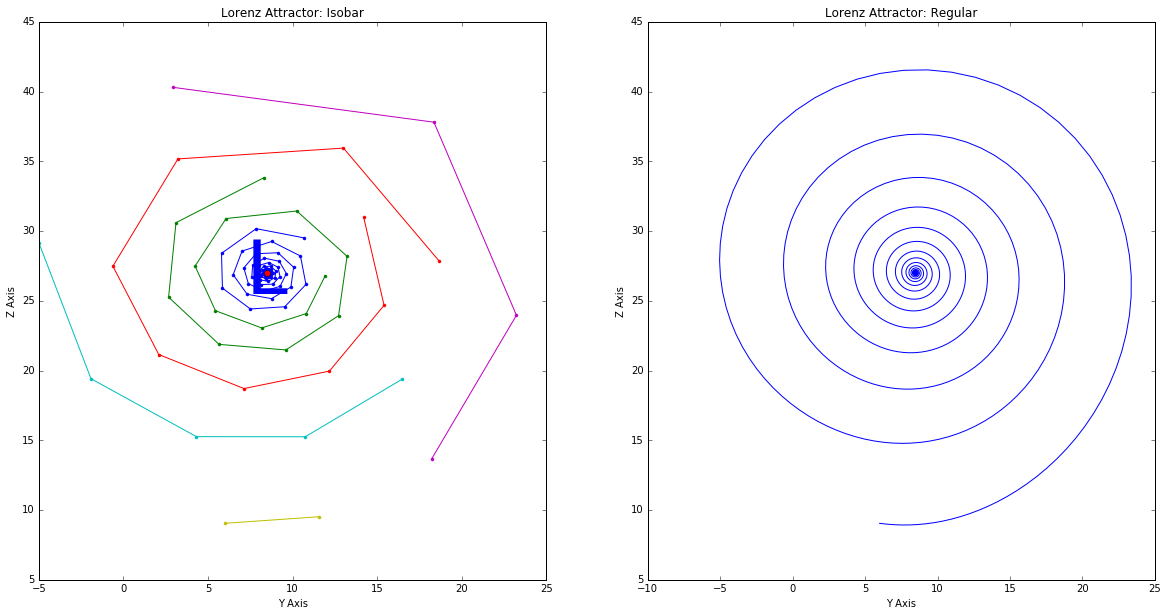

In [32]:
f, (ax1, ax2) = plt.subplots(1, 2)

f.set_figheight(10)
f.set_figwidth(20)

for i in range(len(a_x)):
    if len(a_x[i]) > 0:
        ax1.plot(a_x[i], a_y[i],'.-')
        
# Graph Center
ax1.plot(y_center[0],z_center[0],'ro')
ax1.text(y_center[0], z_center[0], 'L',
         verticalalignment='center', horizontalalignment='center',
         color='blue', fontsize=75)


ax1.set_xlabel("Y Axis")
ax1.set_ylabel("Z Axis")
ax1.set_title("Lorenz Attractor: Isobar")


ax2.plot(ys, zs)
ax2.set_xlabel("Y Axis")
ax2.set_ylabel("Z Axis")
ax2.set_title("Lorenz Attractor: Regular")

plt.show()

# Point Density

In [33]:
def flatten_arr(arr):
    '''
    flatten array
    
    Parameters:
        arr - array[[...],[...],...] to be flattened
        
    Return:
        arr - arr that is now flattened
    '''
    return [val for sublist in arr for val in sublist]

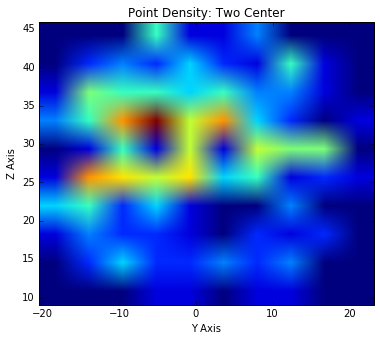

In [34]:
heatmap, xedges, yedges = np.histogram2d(flatten_arr(low_x) + flatten_arr(high_x), 
                                         flatten_arr(low_y) + flatten_arr(high_y))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(6)
ax1 = fig.gca()
ax1.set_xlabel("Y Axis")
ax1.set_ylabel("Z Axis")
ax1.set_title("Point Density: Two Center")
plt.imshow(heatmap, extent=extent)
plt.show()

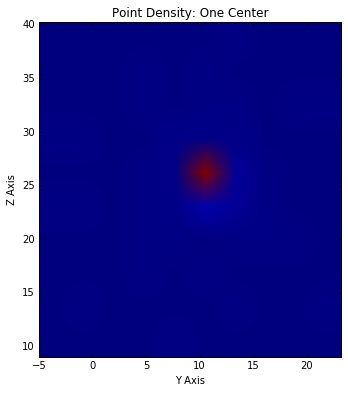

In [35]:
heatmap, xedges, yedges = np.histogram2d([val for sublist in a_x for val in sublist], \
                                         [val for sublist in a_y for val in sublist])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
fig = plt.figure()
ax1 = fig.gca()
fig.set_figheight(6)
fig.set_figwidth(6)
ax1.set_xlabel("Y Axis")
ax1.set_ylabel("Z Axis")
ax1.set_title("Point Density: One Center")
plt.imshow(heatmap, extent=extent)
plt.show()

# Pressure

In [36]:
# Values found at: http://www.theweatherprediction.com/habyhints2/410/
sea_level_pressure_high_max  = 1086 # highest ever recorded
sea_level_pressure_high_min  = 1013 # average pressure
sea_level_pressure_low_max   = 1000 # standard rain storm
sea_level_pressure_low_min   = 980  # category 1 hurricane
sea_level_pressure_hurricane = 870  # lowest ever recorded hurricane, besdies tornado

In [37]:
def build_pressure_system(attractor_system, minimum, maximum, isHigh=False):
    '''
    Assign pressure to each point in system based on grouping
    
    Parameters:
        attractor_system - system built by convert_groups_low_hi
        minimum          - minimum value for pressure
        maximum          - maximum value for pressure
    '''
    multiplier = 1
    
    # generate random number in range that is multiple of 4
    pressure = random.randrange(minimum, maximum,4)
    
    if isHigh == True:
        multiplier = -1
        pressure += 4 * (len(attractor_system) - 1)
        
    for i in range(len(attractor_system)):
        # loop through points in system
        for j in range(len(attractor_system[i]['data'])):
            # assign pressure
            if attractor_system[i]['data'][j]['dist'] < 4*i:
                attractor_system[i]['data'][j]['pressure'] = pressure + attractor_system[i]['data'][j]['dist']
            else:
                attractor_system[i]['data'][j]['pressure'] = pressure + attractor_system[i]['data'][j]['dist'] - 4*i
            
        pressure = pressure + 4*multiplier

In [38]:
def format_value_plot(pressure_system, key):
    '''
    turn an pressure group into a plottable format
    
    Parameters:
        pressure_system - pressure system created in build_pressure_system
        key             - key to access dictionary value
        
    Return:
        x               - array of x points to plot
        y               - array of y points to plot
        value           - value of keys
    '''
    x = []
    y = []
    values = []
    
    for i in range(len(pressure_system)):
        for j in range(len(pressure_system[i]['data'])):
            x.append(pressure_system[i]['data'][j]['coord'][0])
            y.append(pressure_system[i]['data'][j]['coord'][1])
            values.append(pressure_system[i]['data'][j][key])
    
    return x,y,values

## Graphing Two Center Pressure System

In [39]:
build_pressure_system(low_pressure_group, sea_level_pressure_low_min, sea_level_pressure_low_max)
build_pressure_system(high_pressure_group, sea_level_pressure_high_min, sea_level_pressure_high_max, isHigh=True)
build_pressure_system(attractor_groups, sea_level_pressure_hurricane, sea_level_pressure_low_min)

In [40]:
low_x, low_y, low_pressure    = format_value_plot(low_pressure_group, 'pressure')
high_x, high_y, high_pressure = format_value_plot(high_pressure_group, 'pressure')

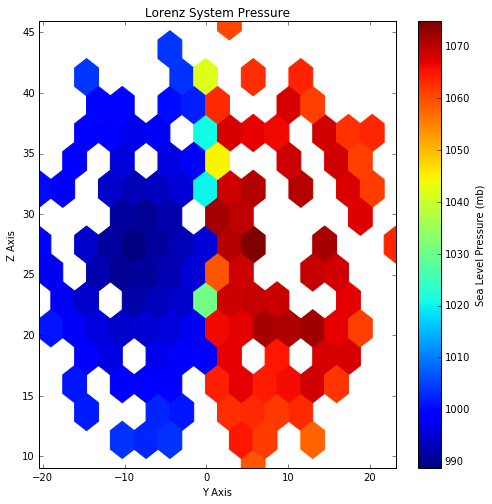

In [41]:
fig = plt.figure()
ax = fig.gca()

fig.set_figwidth(8)
fig.set_figheight(8)

gridsize=30
plt.hexbin(low_x + high_x, (low_y + high_y), C=low_pressure + high_pressure, gridsize=15, cmap=cm.jet, bins=None)
plt.axis([min(low_x + high_x), max(low_x + high_x), min(low_y + high_y), max(low_y + high_y)])

ax.set_xlabel("Y Axis")
ax.set_ylabel("Z Axis")
ax.set_title("Lorenz System Pressure")

cb = plt.colorbar()
cb.set_label('Sea Level Pressure (mb)')
plt.show()   

# Temperature

Convert Kelvin to Celcius

$$
T(°C) = KELVIN - 273.15
$$

In [42]:
def kelvin_to_celcius(kelvin_temp):
    '''
    convert kelvin to celcius
    
    Parameters:
        kelvin_temp - temperature in kelvin
        
    Return:
        float - conversion to celcius value
    '''
    return kelvin_temp - 273.15

$$
T = \dfrac{P_v}{R}
$$
```
P - pressure
T - absolute value of temperature
R - density constant
```


In [43]:
air_density_constant = 3.4

def add_temperature(attractor_system):
    '''
    add temperature column to system
    
    Parameters:
        attractor_system - pressure system created in build_pressure_system
    '''
    for i in range(len(attractor_system)):
        # loop through points in system
        for j in range(len(attractor_system[i]['data'])):
            temp = attractor_system[i]['data'][j]['pressure'] / air_density_constant
            attractor_system[i]['data'][j]['temp'] = kelvin_to_celcius(temp)

In [44]:
add_temperature(low_pressure_group)
add_temperature(high_pressure_group)
add_temperature(attractor_groups)

In [45]:
low_x, low_y, low_temp    = format_value_plot(low_pressure_group, 'temp')
high_x, high_y, high_temp = format_value_plot(high_pressure_group, 'temp')
one_x, one_y, one_temp = format_value_plot(attractor_groups, 'temp')

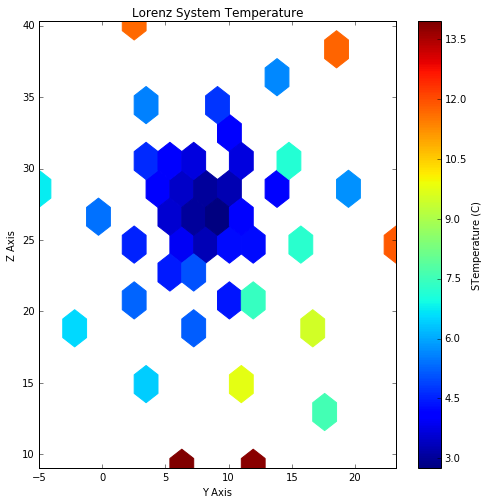

In [46]:
fig = plt.figure()
ax = fig.gca()

fig.set_figwidth(8)
fig.set_figheight(8)

gridsize=30
plt.hexbin(one_x, one_y, C=one_temp, gridsize=15, cmap=cm.jet, bins=None)
plt.axis([min(one_x), max(one_x), min(one_y), max(one_y)])

ax.set_xlabel("Y Axis")
ax.set_ylabel("Z Axis")
ax.set_title("Lorenz System Temperature")

cb = plt.colorbar()
cb.set_label('STemperature (C)')
plt.show()   

# Wind Speed

This portion is particularly difficult as most methods of wind speed calculation require [Wind Profile Power Law](https://en.wikipedia.org/wiki/Wind_profile_power_law) which uses the speed of wind at a different altitude to calculate the speed at the current alittude. We don't have either of these so instead we need to find another way to do it. 

Luckily [Weather Underground](https://www.wunderground.com/) provides free [data](https://www.wunderground.com/history/airport/KPHL/2015/10/11/CustomHistory.html?dayend=11&monthend=10&yearend=2016&req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=&format=1) that we can access and use. We are going to use l2-regression to figure out a basic relationship. Also please note that yes, scikit-learn could be used here but it is not as this will all be turned into C# for my senior design project.

In [47]:
def inch_to_mb(inches):
    '''
    convert inches to millibars
    
    Parameters:
        inches - float to convert
    
    Return:
        - conversion
    '''
    return (1013.25*inches) / 29.92

## Format Data From Weather Underground

In [48]:
mean_pressure_index   = 11
mean_wind_speed_index = 17
page_link = 'https://www.wunderground.com/history/airport/KMIA/2015/10/11/CustomHistory.html?dayend=11&monthend=10&yearend=2016&req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=&format=1'

In [49]:
response = urllib2.urlopen(page_link)
html = response.read()

In [50]:
rows = [row.split(',') for row in html.split('<br />')[1:-1]]
rows = [[float(row[mean_pressure_index]), float(row[mean_wind_speed_index])] for row in rows]

## L2 Regression

In [51]:
def l2_regression(a,b):
    '''
    return line of best fit given points arrays a and b
    
    Parameters:
        a - array of x coordinates
        y - array of y coordinates
        
    Return:
        slope       - slope of line
        y_intercept - y intercept of line
    '''
    # formulate arrays for problem
    l2_matrix = [
        [sum([a[i]**2 for i in range(len(a))]), a.sum()], \
        [a.sum(),                                len(a)]]

    l2_answer = [a.dot(b), 
                 b.sum()]
    
    # solve problem.
    l2 = np.linalg.solve(l2_matrix, l2_answer)
    
    # break into slope and intercept
    return l2[0], l2[1]

In [52]:
def calc_l2_regression_point(point, slope, intercept):
    return (point*slope) + intercept

In [53]:
def calc_l2_line(line_a, slope, intercept):
    return [calc_l2_regression_point(x,slope,intercept) for x in line_a]

In [54]:
a = np.array([inch_to_mb(row[0]) for row in rows])
b = np.array([row[1] for row in rows])

In [55]:
slope, intercept = l2_regression(a,b)
print "slope:", slope
print "inter:", intercept

slope: 0.203528490091
inter: -199.054790677


In [56]:
line_a = range(1000,1030)
line_b = calc_l2_line(line_a, slope, intercept)

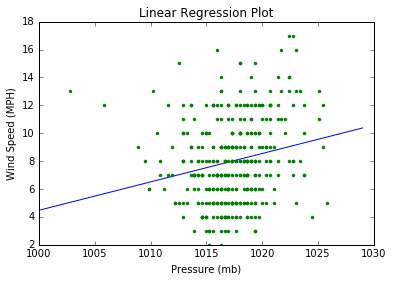

In [57]:
fig = plt.figure()
ax = fig.gca()

ax.plot(line_a, line_b)
ax.plot(a, b,'.')
ax.set_xlabel("Pressure (mb)")
ax.set_ylabel("Wind Speed (MPH)")
ax.set_title("Linear Regression Plot")

plt.show()

Linear regression is missing the relationship that is required for wind speed. Therefore, a quadratic regression approach will be taken too hopefully yield better results.

## Quadratic Regression